# Machine Learning Project

## Objective

The objective of this jupyter notebook, as part of the web service project, is to of to train a model using the data set provided, explain the model and give an analysis of its accuracy.

In [1]:
# import neccessary libaries. Will add to as needs be.
# to plot data
import matplotlib.pyplot as plt
#to load data as a pandas df
import pandas as pd
# to convert data to a numpy array
import numpy as np
%matplotlib inline
# setting some plt parameters that are always useful
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


# Adapted from https://stackoverflow.com/q/43027980
# A magic function that renders the figure in a notebook (instead of displaying a dump of the figure object).


## Load the Data

In [2]:
# reading the file in as csv.
df = pd.read_csv("https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv")
# Making a copy of the data just in case I need it later on.
dfmycopy = df

## Explore the Data

In [3]:
# take a look at the shape: #rows, colums
print("Number of rows:", df.shape[0],"\nNumber of columns: ",df.shape[1])

Number of rows: 500 
Number of columns:  2


In [4]:
# Do any  NaN (null) values exist?
df.isnull().values.any()

False

In [5]:
#take a peak at the first rows  (note to self zero values exist)
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [6]:
#take at the last rows
df.tail()

,speed,power
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0
499,25.000,0.0


In [7]:
# describe the data set. 
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


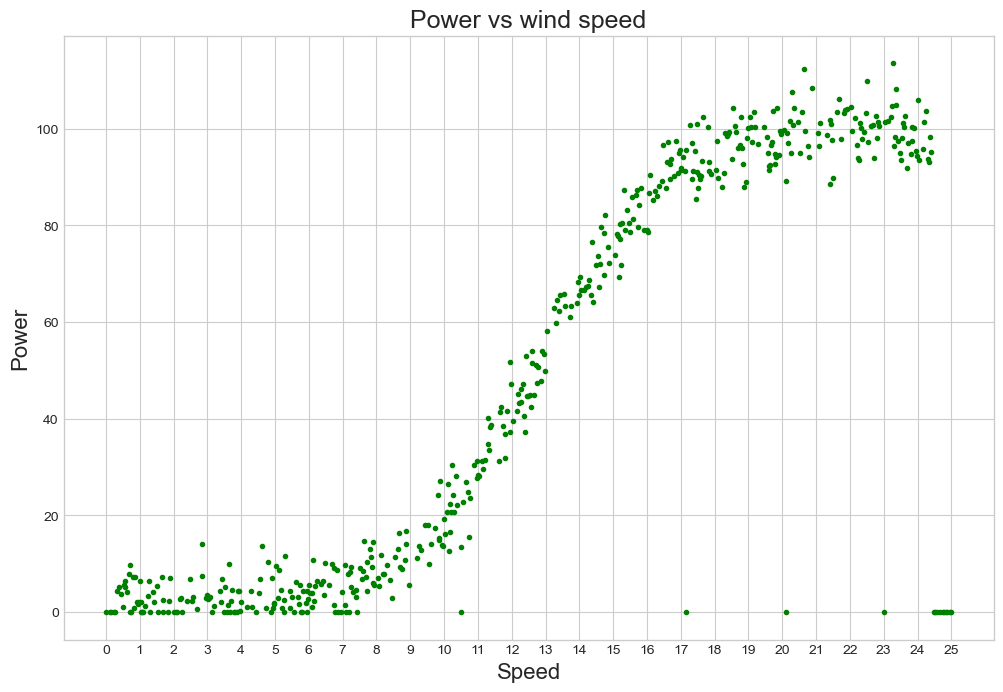

In [8]:

# Plot power versus speed to see if there is a relationship between both. 
plt.plot(df['speed'], df['power'],  '.g')
plt.title('Power vs wind speed', fontsize='18')
plt.xlabel('Speed', fontsize='16')
plt.ylabel('Power', fontsize='16')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.show()

## Initial Visual Observations

From this visual, there appears three regions approximately. In the first region, below speeds of approximately 7.5 the power generated appears low and there does not appear a correlation to speed. One could logically speculate that below a certain speed (threshold) power is not generated (we have all seen still wind turbines) or is at least at low speed the power generated can relatively small or close to zero.

In the second regions, from speed values 7.5 to 10 there appears to be some correlation between speed and power emerging. 

In the third region, from speed values of 10 to 17.5 approx, there appears a rapid growth of power produced.  In otherwords,power generated tends to increase linearly from around speed values of 10 to 17.5. 

In the fourth region, for datapoints with speed values of 17.5 and constant power values are produced. 

But, then there are a number of datapoints with various speed values other than 0 but power produced is zero. **Also there are no speed values beyond approximately 24.5 where there is power generated. 

The below visualization separates those datapoints where power is zero from datapoints where power was actually generated.

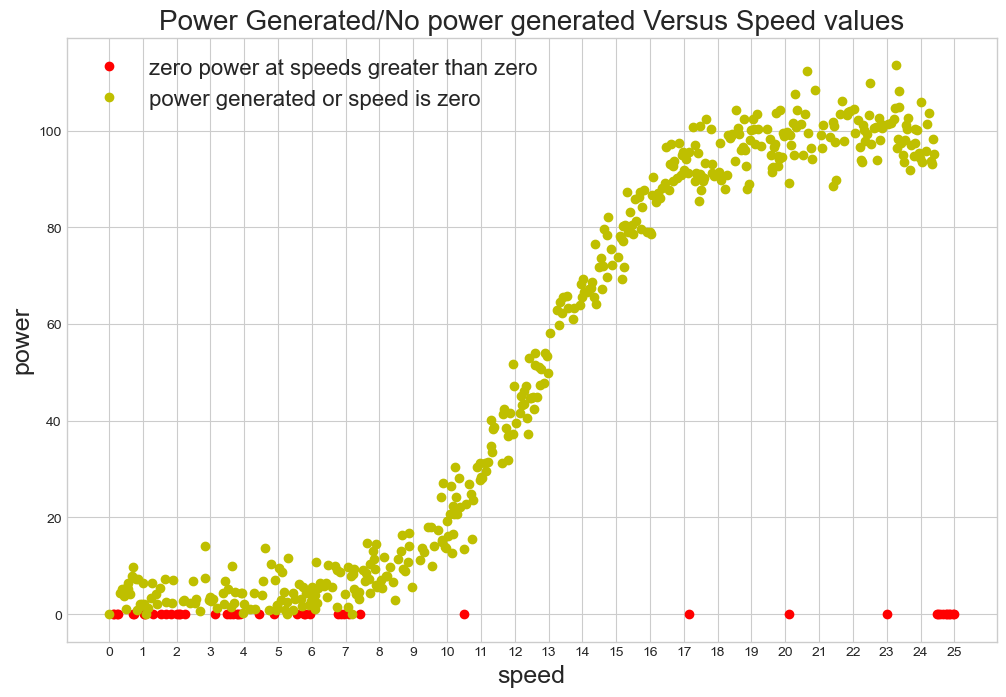

In [11]:

#Selecting rows based on certain conditions
# Adapted from https://stackoverflow.com/a/17071908 
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.title('Power Generated/No power generated Versus Speed values', fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

## Determing which datapoints to exclude from the models.

### 1. Zero power generated at speeds less than or equal to 7.5 

Before rushing into excluding all values where power is equal to zero. I think it is worth zooming in on the data where speed is less than or equal 7.5.  As the below data visualization shows there are many observations where the power generated is close to zero when speed <=7.5. In my mind these points might legitimize the existance of datapoints with zero power generated when speed <=7.5. So I am reluctant to exclude datapoints where speed <= 7.5 and power generated is zero at this stage. This is the exploratory stage in the process so this decision might well be revisited later after further investigation.

In [14]:
# examining datapoints where speed <=7.5 and power is not generated.
dfc= df.loc[(df['speed']<=7.5)& (df['power']!=0) ]
print(dfc.describe())

            speed       power
count  115.000000  115.000000
mean     4.015539    4.553670
std      2.202909    3.081373
min      0.325000    0.067000
25%      2.039500    2.126000
50%      4.304000    4.187000
75%      5.968500    6.504000
max      7.407000   14.131000


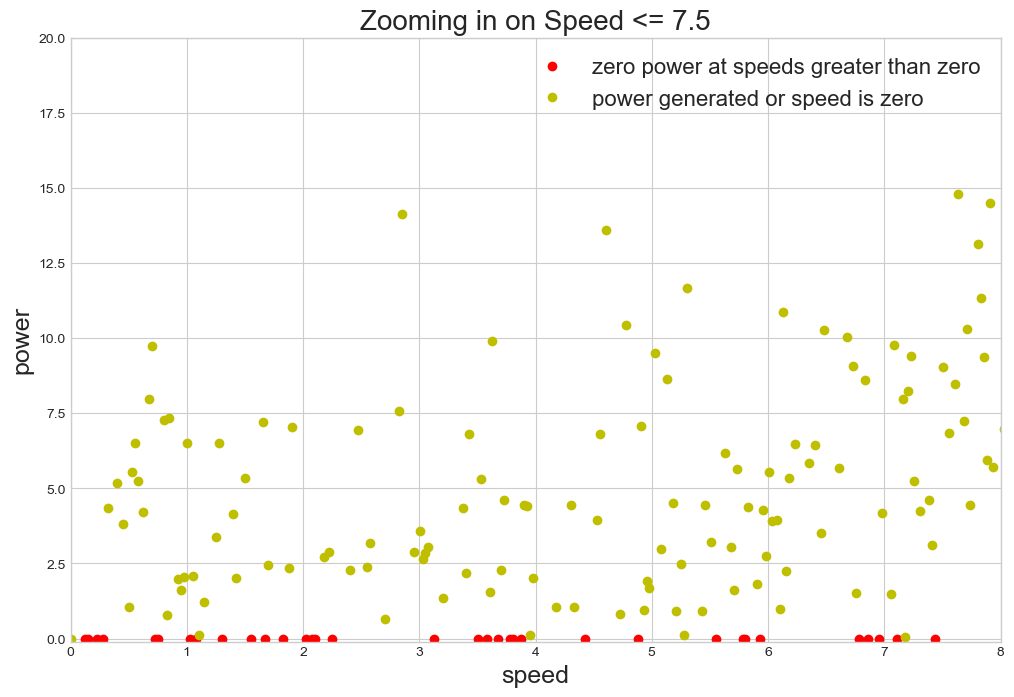

In [13]:
#Selecting rows based on certain conditions
# Adapted from https://stackoverflow.com/a/17071908 
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.title('Zooming in on Speed <= 7.5', fontsize = 20)
plt.legend(fontsize = 16)
plt.xlim(0, 8)
plt.ylim(-0.1,20)
plt.show()


### 2. Zero power generated for speeds > 7.5 

I do think the 4 datapoints with zero power generated and with speed greater than 7.5 but less than 24.5 approxmiately are strong contenders for being dropped from the dataset.  They do seem to be outliers. Outliers are the data instances that stand out amongst other datapoints in the dataset and fail to conform to the normal behavior in a dataset [1],[2].

With regards to zero power generated datapoints with speeds that are greater than 24.5, I am unsure if they should be excluded. But we need to zoom in on the datapoints where speed is greater than 24.
Looking on below figure "Zooming in on Speed <= 24" we can see that **ALL obsversations at speed 24.5 or greater have zero power**.  Therefore I would conclude at this stage that these observations might well be legitimate. Perhaps a wind turbine doesnt function in "high" winds. 

So to summarize, for the moment or until I know more, keep all datapoints with zero power except those datapoints with speed speed greater than 7.5 but less than 24.5 .  

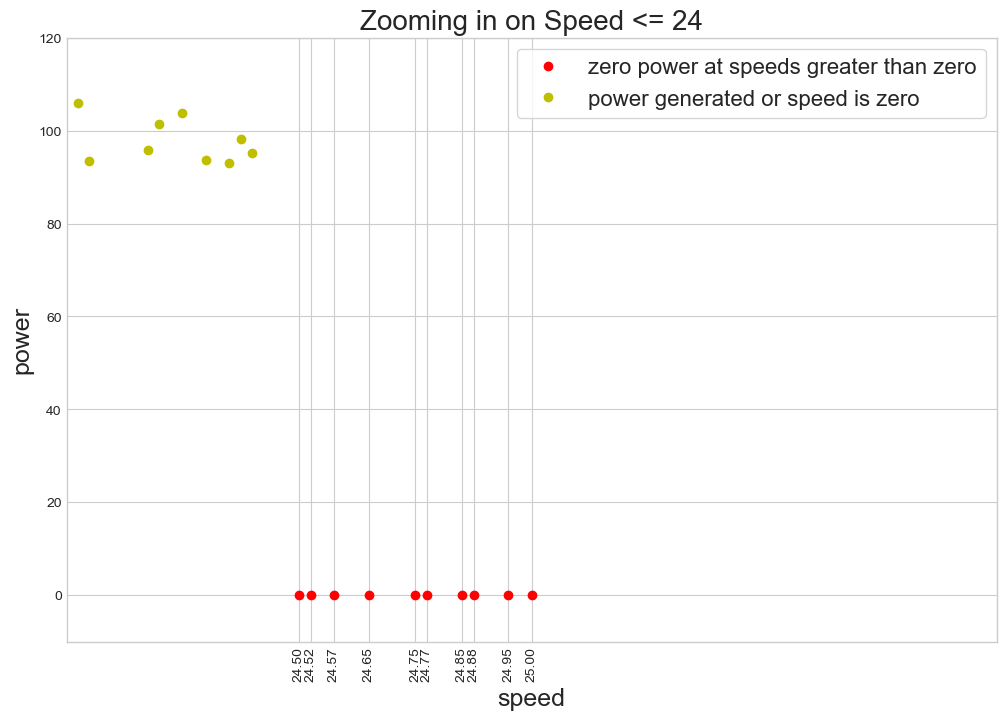

In [24]:
# fix the zoom in 

#Selecting rows based on certain conditions
# Adapted from https://stackoverflow.com/a/17071908 
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(dfa['speed'], rotation=90)
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.title('Zooming in on Speed <= 24', fontsize = 20)
# Adapted from https://stackoverflow.com/questions/25540259/remove-or-adapt-border-of-frame-of-legend-using-matplotlib
plt.legend(fontsize = 16, frameon=True)
plt.xlim(24, 26)
plt.ylim(-10,120)
plt.show()

In [ ]:
# https://stackoverflow.com/a/52456896
df.drop(df.loc[(df['power'] == 0) & ((df.speed > 7.5)&(df.speed <=??????)].index, inplace=True)

In [ ]:
# # Adapted from https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
# coef = np.polyfit(df['power'],df['speed'],1)
# poly1d_fn = np.poly1d(coef) 
# # poly1d_fn is now a function which takes in x and returns an estimate for y
# plt.plot(df['speed'], df['power'],  '.b')
# plt.plot(df['speed'],df['power'], 'yo', x, poly1d_fn(x), '--k')
# # plt.xlim(0, 5)
# # plt.ylim(0, 12)

## References

[1] https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm  
[2] Kotu, V., & Deshpande, B., "Anomaly Detection", Science Direct https://www.sciencedirect.com/topics/computer-science/anomaly-detection  